In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import pickle
from scipy.signal import find_peaks

Food for thought:
1. Is there any connection between oscillation period and the step size?
2. What about the system with damped oscillations?

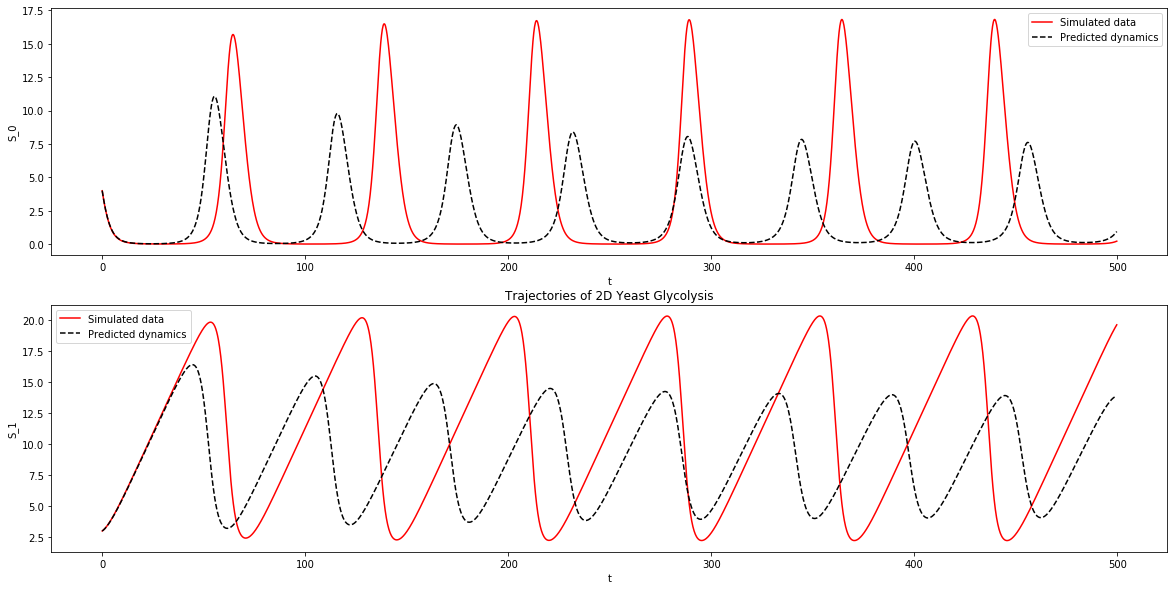

In [3]:
# step size h = 0.2

with open('bier.pkl', 'rb') as file:
    bier = pickle.load(file)

time_points = bier['t']
bier_pred = bier['pred']
bier_data = bier['data'].reshape(-1,2)

plt.figure(figsize=(20, 10))

for species in range(2):
    plt.subplot(2,1,species + 1)
    plt.plot(time_points, bier_data[:, species], 'r-', label='Simulated data')
    plt.plot(time_points, bier_pred[:,species], 'k--', label='Predicted dynamics')
    plt.xlabel('t')
    plt.ylabel('S_' + str(species))
    plt.legend()
    
plt.title('Trajectories of 2D Yeast Glycolysis')
plt.show()

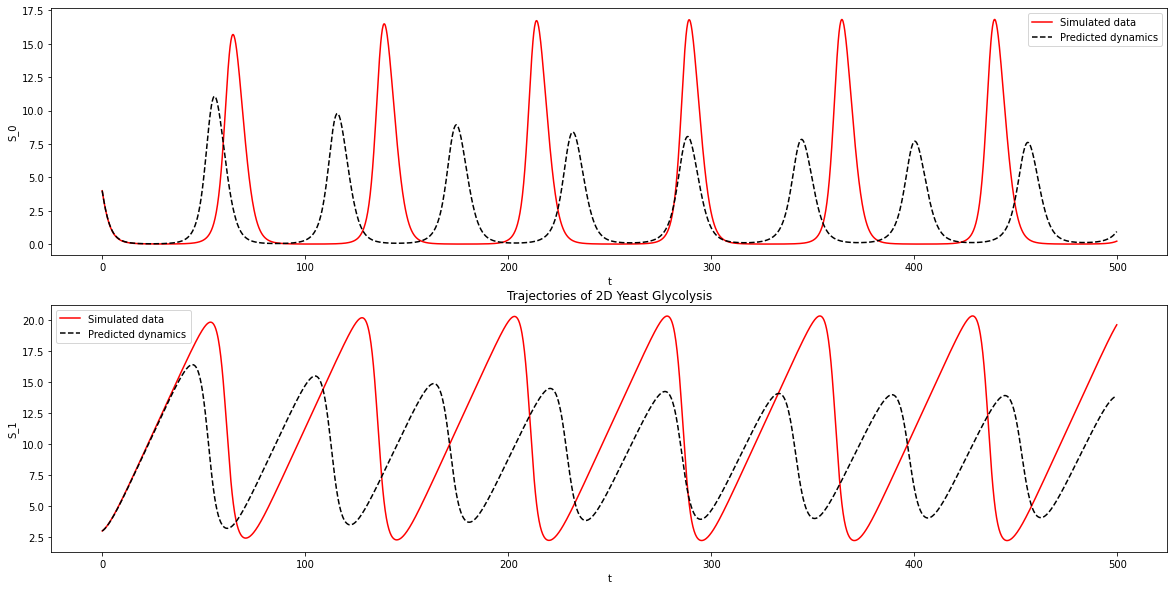

In [2]:
# step size h = 0.2

with open('data/bier_oscillator.pkl', 'rb') as file:
    bier = pickle.load(file)

time_points = bier['t']
bier_pred = bier['pred']
bier_data = bier['data'].reshape(-1,2)

plt.figure(figsize=(20, 10))

for species in range(2):
    plt.subplot(2,1,species + 1)
    plt.plot(time_points, bier_data[:, species], 'r-', label='Simulated data')
    plt.plot(time_points, bier_pred[:,species], 'k--', label='Predicted dynamics')
    plt.xlabel('t')
    plt.ylabel('S_' + str(species))
    plt.legend()
    
plt.title('Trajectories of 2D Yeast Glycolysis')
plt.show()

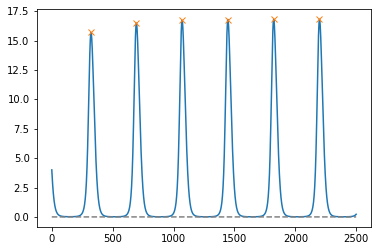

In [8]:
# check the period
x = bier_data[:,0]
peaks, _ = find_peaks(x, height=0)
plt.plot(x)
plt.plot(peaks, x[peaks], "x")
plt.plot(np.zeros_like(x), "--", color="gray")
plt.show()

In [9]:
for i in range(len(peaks)-1):
    print(peaks[i + 1] - peaks[i])

373
375
376
376
376


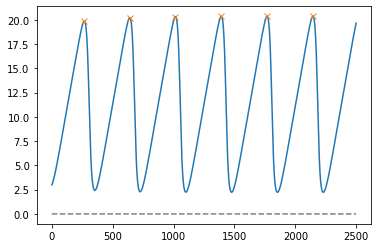

In [10]:
# check the period
x = bier_data[:,1]
peaks, _ = find_peaks(x, height=0)
plt.plot(x)
plt.plot(peaks, x[peaks], "x")
plt.plot(np.zeros_like(x), "--", color="gray")
plt.show()

In [11]:
for i in range(len(peaks)-1):
    print(peaks[i + 1] - peaks[i])

373
375
377
376
376


Text(0.5, 1.0, 'Phase plane of 2D Yeast Glycolysis')

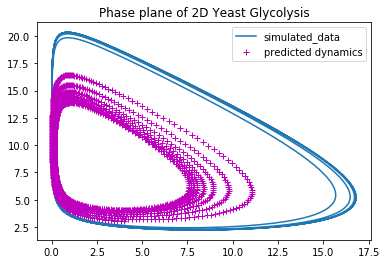

In [4]:
# Phase plane

plt.plot(bier_data[:,0], bier_data[:,1], label='simulated_data')
plt.legend()
plt.plot(bier_pred[:,0], bier_pred[:,1], 'm+', label='predicted dynamics')
plt.legend()
plt.title('Phase plane of 2D Yeast Glycolysis')

Remark: the period here is much longer than the period for the 7-D glycolysis.

# Damped Oscillations

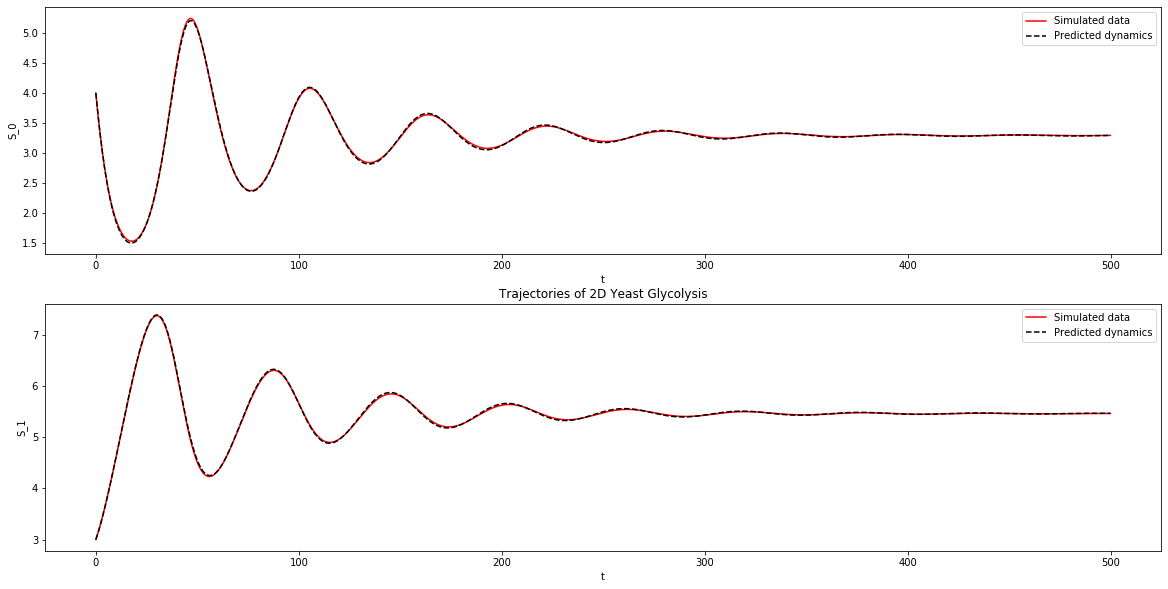

In [3]:
# step size h = 0.2

with open('bier_damped.pkl', 'rb') as file:
    bier = pickle.load(file)

time_points = bier['t']
bier_pred = bier['pred']
bier_data = bier['data'].reshape(-1,2)

plt.figure(figsize=(20, 10))

for species in range(2):
    plt.subplot(2,1,species + 1)
    plt.plot(time_points, bier_data[:, species], 'r-', label='Simulated data')
    plt.plot(time_points, bier_pred[:,species], 'k--', label='Predicted dynamics')
    plt.xlabel('t')
    plt.ylabel('S_' + str(species))
    plt.legend()
    
plt.title('Trajectories of 2D Yeast Glycolysis')
plt.show()

# Step size dependence of the network

Tasks:
* Check step size dependence of BDF and AB for 1 step when applied to 2-D Harmonic Oscillator

In [1]:
from source.train import *
from source.model import lmmNet
from source.predict import *

In [7]:
# train AB with different step sizes for the cubic system

# parameters for the cubic system
t0 = 0
T = 25
h = 0.01
x0 = np.array([2,0])

# parameters for the LmmNet
hidden_layer_units = 256 # number of units for the hidden layer
M = 1 # number of steps
scheme = 'AB' # LMM scheme

time_points, bier_data = create_training_data(t0, T, h, f_cubic, x0)

# for storing results
result_dict = {}
result_dict['data'] = bier_data
result_dict['t'] = time_points

step_list = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2]
for h in step_list:
    print('Training LmmNet for h = ', h)
    model = lmmNet(h, bier_data, M, scheme, hidden_units=hidden_layer_units)
    model.train(10000)

    pred = odeint(predict_fn, x0, time_points, args=(model,))

    # store the result
    result_dict[str(h) + '_pred'] = pred
    result_dict[str(h) + '_f'] = [predict_fn(x, None, model) for x in np.squeeze(bier_data)]

Training LmmNet for h =  0.001
Training LmmNet for h =  0.002
Training LmmNet for h =  0.005
Training LmmNet for h =  0.01
Training LmmNet for h =  0.02
Training LmmNet for h =  0.05
Training LmmNet for h =  0.1
Training LmmNet for h =  0.2


In [13]:
import matplotlib.pyplot as plt
# note that we name the data bier_data still but it's Cubic problem
errorx = []
errory = []

for step in step_list:
    key = str(step) + '_pred'
    errorx.append(compute_MSE(result_dict[key], bier_data, 0))
    errory.append(compute_MSE(result_dict[key], bier_data, 1) )


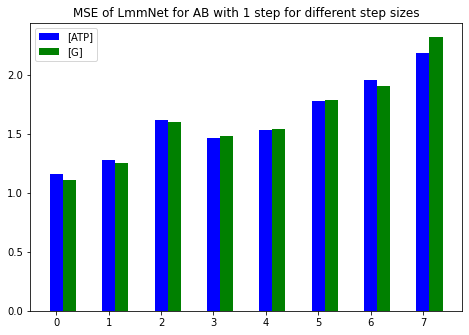

In [12]:
data = [errorx, errory]
fig = plt.figure()
X = np.arange(len(step_list))
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, data[0], color = 'b', width = 0.25)
ax.bar(X + 0.25, data[1], color = 'g', width = 0.25)
#ax.bar(X + 0.50, data[2], color = 'r', width = 0.25)

#ax.set_xticks(X, ('G1', 'G2', 'G3', 'G4', 'G5'))
ax.set_title('MSE of LmmNet for AB with 1 step for different step sizes')
ax.legend(labels=['[ATP]', '[G]'])
plt.show()

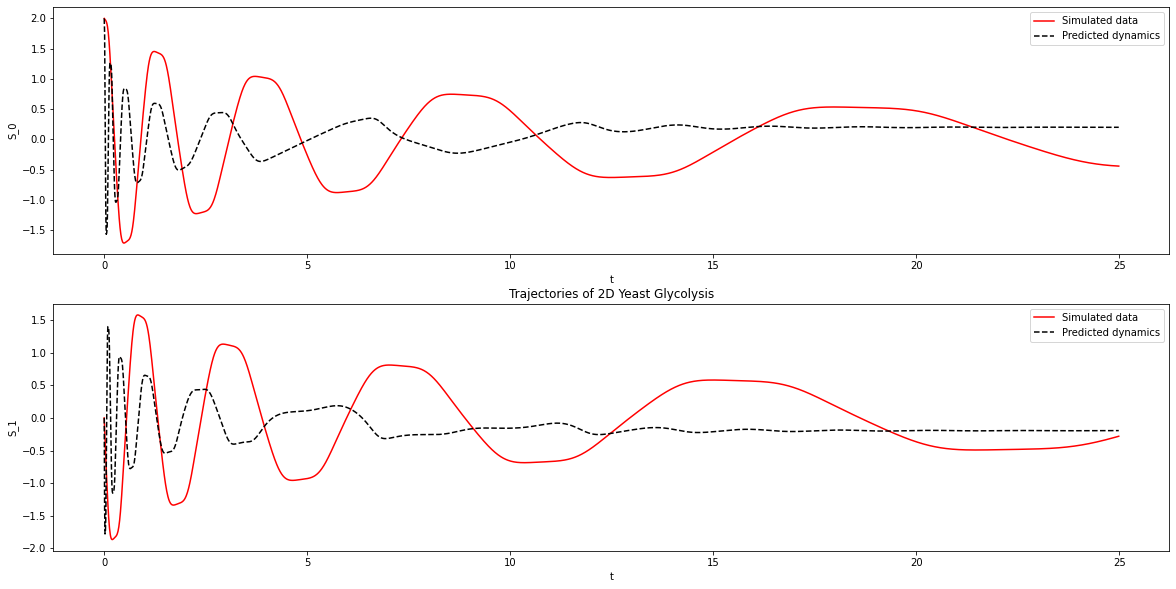

In [15]:
# plot the time-course
bier_pred = result_dict['0.001_pred']

plt.figure(figsize=(20, 10))

for species in range(2):
    plt.subplot(2,1,species + 1)
    plt.plot(time_points, bier_data[0,:, species], 'r-', label='Simulated data')
    plt.plot(time_points, bier_pred[:,species], 'k--', label='Predicted dynamics')
    plt.xlabel('t')
    plt.ylabel('S_' + str(species))
    plt.legend()
    
plt.title('Trajectories of 2D Harmonic Oscillator')
plt.show()

In [16]:
# train AB with different step sizes for the cubic system

# parameters for the cubic system
t0 = 0
T = 25
h = 0.01
x0 = np.array([2,0])

# parameters for the LmmNet
hidden_layer_units = 256 # number of units for the hidden layer
M = 1 # number of steps
scheme = 'BDF' # LMM scheme

time_points, bier_data = create_training_data(t0, T, h, f_cubic, x0)

# for storing results
result_dict = {}
result_dict['data'] = bier_data
result_dict['t'] = time_points

step_list = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2]
for h in step_list:
    print('Training LmmNet for h = ', h)
    model = lmmNet(h, bier_data, M, scheme, hidden_units=hidden_layer_units)
    model.train(10000)

    pred = odeint(predict_fn, x0, time_points, args=(model,))

    # store the result
    result_dict[str(h) + '_pred'] = pred
    result_dict[str(h) + '_f'] = [predict_fn(x, None, model) for x in np.squeeze(bier_data)]

Training LmmNet for h =  0.001
Training LmmNet for h =  0.002
Training LmmNet for h =  0.005
Training LmmNet for h =  0.01
Training LmmNet for h =  0.02
Training LmmNet for h =  0.05
Training LmmNet for h =  0.1
Training LmmNet for h =  0.2


In [17]:
import matplotlib.pyplot as plt
# note that we name the data bier_data still but it's Cubic problem
errorx = []
errory = []

for step in step_list:
    key = str(step) + '_pred'
    errorx.append(compute_MSE(result_dict[key], bier_data, 0))
    errory.append(compute_MSE(result_dict[key], bier_data, 1) )


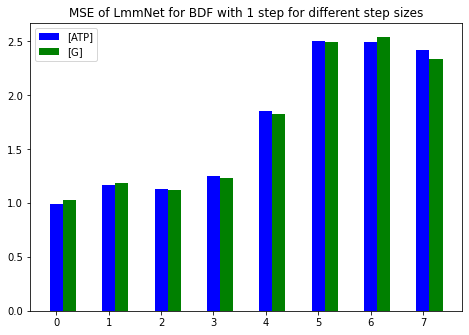

In [18]:
data = [errorx, errory]
fig = plt.figure()
X = np.arange(len(step_list))
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, data[0], color = 'b', width = 0.25)
ax.bar(X + 0.25, data[1], color = 'g', width = 0.25)
#ax.bar(X + 0.50, data[2], color = 'r', width = 0.25)

#ax.set_xticks(X, ('G1', 'G2', 'G3', 'G4', 'G5'))
ax.set_title('MSE of LmmNet for BDF with 1 step for different step sizes')
ax.legend(labels=['[ATP]', '[G]'])
plt.show()

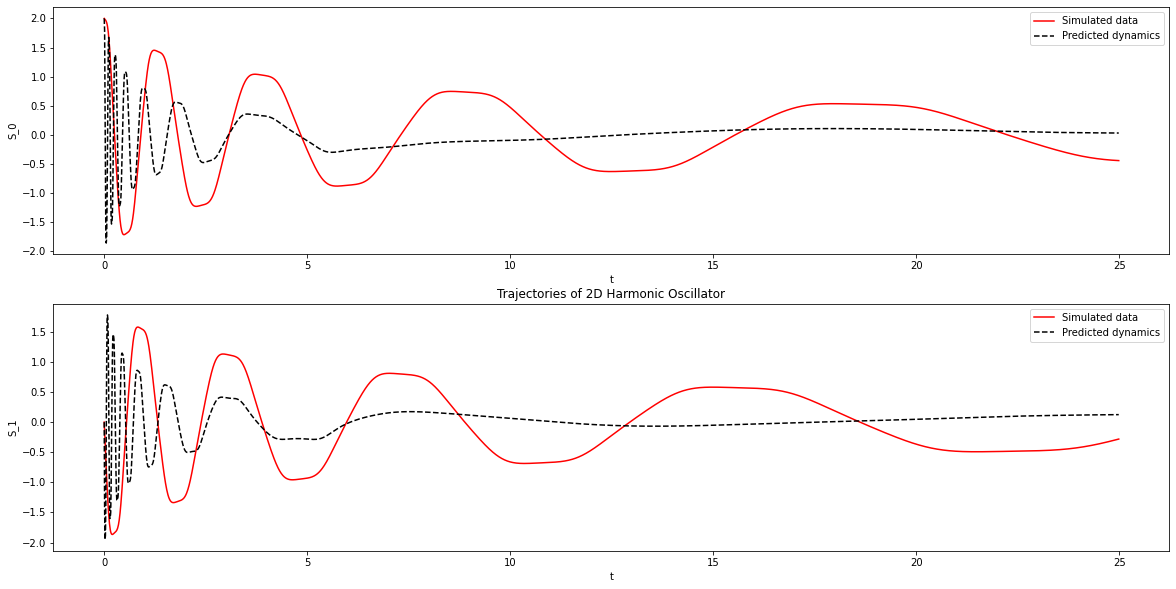

In [19]:
# plot the time-course
bier_pred = result_dict['0.001_pred']

plt.figure(figsize=(20, 10))

for species in range(2):
    plt.subplot(2,1,species + 1)
    plt.plot(time_points, bier_data[0,:, species], 'r-', label='Simulated data')
    plt.plot(time_points, bier_pred[:,species], 'k--', label='Predicted dynamics')
    plt.xlabel('t')
    plt.ylabel('S_' + str(species))
    plt.legend()
    
plt.title('Trajectories of 2D Harmonic Oscillator')
plt.show()